In [1]:
from __future__ import print_function
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Genomics example

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:

- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

### Read in and one-hot encode the data

In [3]:
import gzip
import re
from collections import OrderedDict

def load_sequences(seqfile):
        seqs = OrderedDict()
        fp = gzip.open(seqfile, "rb")
        print("#Loading " + seqfile + " ...")
        expecting = "label"
        label=''
        for line in fp:
                if expecting == "label":
                        match = re.match(">(.*)$", line)
                        if match:
                                label = match.group(1)
                                expecting = "sequence"
                        else:
                                print("Expecting LABEL but found (!!): " + line)
                                continue
                else:
                        match = re.match("(\w+)$", line)
                        if match:
                                sequence = match.group(1)
                                seqs[label]=sequence
                        else:
                                print("Expecting SEQUENCE but found (!!): " + line)
                        expecting = "label"
                        label=''
        fp.close()
        print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
        return seqs

In [4]:
def load_sequences_from_bedfile(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        (label, sequence)=line.split()
        seqs[label]=sequence
    fp.close()
    print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
    return seqs
    

In [5]:
def get_value(label):
    value = -1
    match = re.match("((dinuc_shuff_|dinuc_shuffled_).+)$", label)
    if match:            
        chrom = match.group(1)
        if match.group(2) == 'dinuc_shuff_':
            value = 0
        else:
            value = 1
    return value        

In [6]:
import random
def get_random_set(seqdict, num, sort=True):
    newlist=seqdict.items()
    if sort:
        newlist = [newlist[i] for i in sorted(random.sample(range(len(newlist)), num))]
    else:
        newlist = [newlist[i] for i in random.sample(range(len(newlist)), num)]
    return dict(newlist)

In [7]:
import numpy as np

data_filename_positive = "/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz"
#data_filename_negative = "/users/eprakash/projects/benchmarking/newdata/GM12878/400bp/universal_dnase.matched.GM12878.summits.400bp.hg38.implanted.bed.gz"
positives=load_sequences_from_bedfile(data_filename_positive)
labeled_sequences = load_sequences_from_bedfile(data_filename_positive)
#del labeled_sequences['chr1:203649072-203650072']
print("Got %d positive sequences" % len(labeled_sequences))
positive_labels = labeled_sequences.keys()
#neg_seqs = load_sequences_from_bedfile(data_filename_negative)
#del neg_seqs['chr1:203649072-203650072']
#neg_seqs = get_random_set(neg_seqs, 200000)
#print("Got %d negative sequences" % len(neg_seqs))
#negative_labels = neg_seqs.keys()
#print("Number of labels common to both sets of sequences is %d " % len(set(positive_labels).intersection(set(negative_labels))))
#labeled_sequences.update(neg_seqs)
#labeled_sequences=get_random_set(labeled_sequences, 74499, sort=False)
labels = labeled_sequences.keys()
sequences=labeled_sequences.values()
#values = np.array([get_value(label) for label in labels])
#check_negatives = np.nonzero(values == -1)[0]
#assert (len(check_negatives) == 0)
#print("Labels length: ", len(labels))
print("Sequences length: ", len(sequences))
#print("Values length: ", len(values))

#Loading /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz ...
#Loaded 5000 sequences from /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz
#Loading /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz ...
#Loaded 5000 sequences from /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz
Got 5000 positive sequences
Sequences length:  5000


In [8]:
removed=[]
chars=['R','Y','S','W','K','M','B','D','H','V','N']
print(len(sequences))
for seq in sequences:
    if any((c in chars) for c in seq):
        print(seq)
        removed.append(seq)
        sequences.remove(seq)
print(len(sequences))

5000
5000


In [9]:
for i in removed:
    key=labeled_sequences.keys()[labeled_sequences.values().index(i)]
    print(key)
    del labeled_sequences[key]
    labels.remove(key)
print (len(labels))
print(len(labeled_sequences))

5000
5000


One-hot encode the data

In [10]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
#sequences = sequences[-5000:]            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in sequences])

In [11]:
print(onehot_data.shape)

(5000, 400, 4)


### Load the keras model

In [12]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.5'

In [13]:
from keras.models import model_from_json

def load_keras_model_using_json(json_file_name, h5_weights_file):
    json_file = open(json_file_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    print("Loading Keras JSON model from file " + json_file_name)
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    print("Loading Keras model weights from file " + h5_weights_file)
    loaded_model.load_weights(h5_weights_file)
    print("Successfully loaded")
    return loaded_model

In [14]:

import deeplift
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model

#keras_model = load_model('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/adaptDeepSeaKerasModel.h5')
keras_model = load_keras_model_using_json("/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelJson.json", "/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelWeights.h5")
keras_model.summary()
'''
with tf.device('/gpu:3'):
#load the keras model
    keras_model_weights = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelWeights.h5"
    keras_model_json = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelJson.json"

    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    keras_model=load_h5_model('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/deepseabeluga_keras.h5')'''

Loading Keras JSON model from file /users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelJson.json
Loading Keras model weights from file /users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelWeights.h5
Successfully loaded
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 393, 320)          10560     
_________________________________________________________________
activation_1 (Activation)    (None, 393, 320)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 386, 320)          819520    
_________________________________________________________________
activation_2 (Activation

'\nwith tf.device(\'/gpu:3\'):\n#load the keras model\n    keras_model_weights = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelWeights.h5"\n    keras_model_json = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelJson.json"\n\n    keras_model = model_from_json(open(keras_model_json).read())\n    keras_model.load_weights(keras_model_weights)\n    keras_model=load_h5_model(\'/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/deepseabeluga_keras.h5\')'

In [15]:
preds = keras_model.predict(onehot_data)
preds.shape

(5000, 1)

In [16]:
print (len(sequences))
print(np.sum(1-preds)/preds.shape[0])

5000
0.006700392913818359


In [17]:
true_labels=[]
for label in labels:
    if label in positive_labels:
        true_labels.append(1)
    elif label in negative_labels:
        true_labels.append(0)
    else:
        continue
print(len(true_labels))

5000


In [18]:
preds.shape[1]

1

In [19]:
from sklearn.metrics import roc_auc_score
#aurocs=np.zeros((preds.shape[1]))
#print(aurocs.shape)
#for i in range(0,preds.shape[1]):
#    auroc = roc_auc_score(y_true=true_labels, y_score=preds[:,i])
#    aurocs[i]=auroc
#auroc = roc_auc_score(y_true=true_labels, y_score=preds[:,0])

In [20]:
#print(max(aurocs))

In [21]:
seq_id_to_pred={}
for index in range(0,len(labels)):
    label=labels[index]
    if label in positive_labels:
        seq_id_to_pred.update({label:preds[index][0]})
print(len(seq_id_to_pred))
print(len(positive_labels))

5000
5000


In [22]:
top_1k_pos_labels=sorted(seq_id_to_pred, key=lambda x: seq_id_to_pred[x])[-1000:]
top_1k_pos=[]
for label in top_1k_pos_labels:
    top_1k_pos.append(positives[label])
print(len(top_1k_pos_labels))
print(top_1k_pos_labels[0:5])

1000
['dinuc_shuffled_motifs_implanted_chrX:54044271-54044671', 'dinuc_shuffled_motifs_implanted_chr14:53613531-53613931', 'dinuc_shuffled_motifs_implanted_chr6:2764503-2764903', 'dinuc_shuffled_motifs_implanted_chr5:84249856-84250256', 'dinuc_shuffled_motifs_implanted_chr11:95089524-95089924']


In [23]:
print(seq_id_to_pred.items()[0:5])

[('dinuc_shuffled_motifs_implanted_chr6:136517027-136517427', 0.99996066), ('dinuc_shuffled_motifs_implanted_chr14:77033993-77034393', 0.9999689), ('dinuc_shuffled_motifs_implanted_chr17:48804883-48805283', 0.99543285), ('dinuc_shuffled_motifs_implanted_chr1:26991274-26991674', 0.98465157), ('dinuc_shuffled_motifs_implanted_chr12:79738102-79738502', 0.9999479)]


In [24]:
import h5py

h5f = h5py.File('/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/results/top1kposlabels_A549_1kb', 'w')
h5f.create_dataset("labels", data=top_1k_pos_labels)
h5f.close()

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT (with 3 different variants: rescale on the conv layers and revealcancel on the fully-connected layers (the genomics default), rescale on all layers, and revealcancel on all layers), gradients and guided backprop


In [25]:
#keras_model.save_weights('gm12878_weights.h5')
#with open('gm12878_model_architecture.json', 'w') as f:
#    f.write(keras_model.to_json())

In [26]:
keras_model_weights='/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelWeights.h5'
keras_model_json='/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelJson.json'

In [27]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
reload(deeplift.layers)
reload(deeplift.conversion.kerasapi_conversion)
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 6 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 9 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 13 the preceding lin

### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: https://github.com/kundajelab/deeplift/issues/54

In [28]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [29]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


### Call scoring functions on the data

In the cell below, a reference representing 40% GC content is used

In [30]:
#background = OrderedDict([('A', 0.0), ('C', 0.0), ('G', 0.0), ('T', 0.0)])
avg_gc_content = np.mean(onehot_data, axis=(0,1))
print(avg_gc_content)
background = OrderedDict([('A', avg_gc_content[0]), ('C', avg_gc_content[1]), ('G', avg_gc_content[2]), ('T', avg_gc_content[3])])
print(background)

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print (method_to_scoring_func.keys())
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    print("scorefunc ", score_func)
    if (not (method_name == "rescale_all_layers" or method_name == "integrated_gradients10")):
        continue
    method_variation_avg_gc_ref = method_name + "_avg_gc_ref"
    method_variation_all_zeros_ref = method_name + "_all_zeros_ref"
    method_to_task_to_scores[method_variation_avg_gc_ref] = OrderedDict()
    method_to_task_to_scores[method_variation_all_zeros_ref] = OrderedDict()
    for task_idx in [0]:
        print("On method variation: " + method_variation_avg_gc_ref)
        scores = np.array(score_func(
        task_idx=task_idx,
        input_data_list=[onehot_data],
        input_references_list=[
        np.array([background['A'],
                background['C'],
                background['G'],
                background['T']])[None,None,:]],
                batch_size=200,
                progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_variation_avg_gc_ref][task_idx] = scores
        # Second time for zeros ref
        print("On method variation: " + method_variation_all_zeros_ref)
        scores = np.array(score_func(
        task_idx=task_idx,
        input_data_list=[onehot_data],
        input_references_list=[
        np.array([0,0,0,0])[None,None,:]],
                batch_size=200,
                progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_variation_all_zeros_ref][task_idx] = scores

[0.232586 0.266258 0.26742  0.233736]
OrderedDict([('A', 0.232586), ('C', 0.266258), ('G', 0.26742), ('T', 0.233736)])
['rescale_conv_revealcancel_fc', 'rescale_all_layers', 'revealcancel_all_layers', 'grad_times_inp', 'guided_backprop', 'integrated_gradients10']
on method rescale_conv_revealcancel_fc
scorefunc  <function func at 0x7fda046d5b18>
on method rescale_all_layers
scorefunc  <function func at 0x7fda0405eaa0>
On method variation: rescale_all_layers_avg_gc_ref
On method variation: rescale_all_layers_all_zeros_ref
on method revealcancel_all_layers
scorefunc  <function func at 0x7fd9c039daa0>
on method grad_times_inp
scorefunc  <function func at 0x7fd9aade2578>
on method guided_backprop
scorefunc  <function func at 0x7fd9aade2230>
on method integrated_gradients10
scorefunc  <function compute_integrated_gradients at 0x7fd9aa5861b8>
On method variation: integrated_gradients10_avg_gc_ref
On method variation: integrated_gradients10_all_zeros_ref


In [31]:
print(scores.shape)

(5000, 400)


In [32]:
print(method_to_task_to_scores.keys())

['rescale_all_layers_avg_gc_ref', 'rescale_all_layers_all_zeros_ref', 'integrated_gradients10_avg_gc_ref', 'integrated_gradients10_all_zeros_ref']


### Save scores to HDF5 file

In [33]:
print(method_to_task_to_scores.keys())

['rescale_all_layers_avg_gc_ref', 'rescale_all_layers_all_zeros_ref', 'integrated_gradients10_avg_gc_ref', 'integrated_gradients10_all_zeros_ref']


In [34]:
import h5py

h5f = h5py.File('/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/results/A549.deepseabeluga.scores.variedrefs.5Ksubsample.h5', 'w')
h5f.create_dataset("labels", data=labels)
for meth in method_to_task_to_scores.keys()[0:4]:
    print("Storing scores for " + str(meth))
    h5f.create_dataset(meth, data=method_to_task_to_scores[meth][0])
h5f.close()

Storing scores for rescale_all_layers_avg_gc_ref
Storing scores for rescale_all_layers_all_zeros_ref
Storing scores for integrated_gradients10_avg_gc_ref
Storing scores for integrated_gradients10_all_zeros_ref


## Visualize scores on individual sequences

Visualize the scores at specific sequences. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 0 for example 731
[-1.59996314e-04  3.21276719e-04 -1.05499057e-03  1.48633868e-03
  2.00503226e-03 -9.43981810e-04 -7.79897906e-04 -3.22132325e-03
  1.61739513e-02  1.81173515e-02  2.29527745e-02  2.95779924e-03
  7.19583826e-03  3.95067707e-02  9.08019394e-03  1.51554262e-02
  7.60926008e-02  7.92516917e-02  2.50487141e-02  6.10106140e-02
  4.10877392e-02  1.30185783e-02  1.88799091e-02  3.61201614e-02
  1.01437233e-02  1.79307461e-02 -1.25843333e-03  5.63985389e-03
 -2.40565799e-02  2.44209003e-02  4.19569649e-02  6.28873780e-02
 -3.36681195e-02 -1.44017264e-02 -5.06903045e-04  1.52270701e-02
  1.11479782e-01  1.85794115e-01  1.46664158e-01  6.66365102e-02
 -4.91777137e-02 -2.13025659e-02 -1.75352097e-02 -2.87101809e-02
 -1.08926771e-02  6.16517626e-02  6.55350983e-02  1.70727298e-01
  1.88247710e-01  2.29588836e-01  2.18060762e-01  1.71752572e-01
  2.77276307e-01  1.52305812e-01  2.61476934e-02  4.33534309e-02
 -2.62724385e-02 -1.21417986e-02 -2.13566199e-02  9.0977

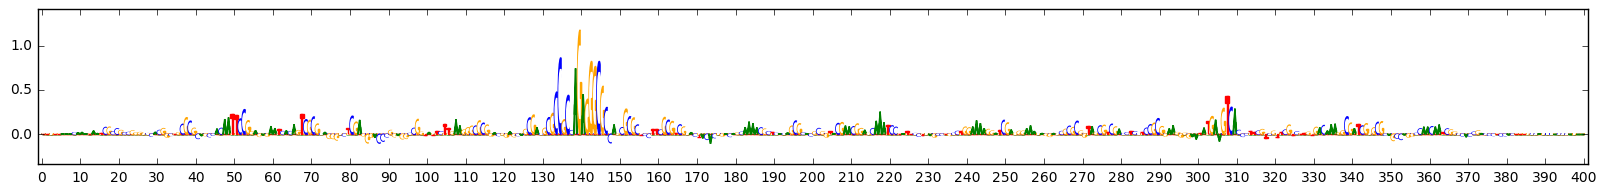

Scores for task 0 for example 197
[ 3.37465084e-04  1.02000893e-03 -5.17681474e-04 -6.51066890e-04
 -4.67817858e-03  8.75310274e-04 -1.04872147e-02  3.95258749e-03
 -8.19943845e-03 -1.27864694e-02 -1.28298216e-02 -1.69929088e-04
  2.60865167e-02  1.09512173e-03  1.41176712e-02  1.91128403e-02
  1.54569726e-02  4.26077358e-02  2.55429950e-02 -1.68771520e-02
 -2.11906107e-03  1.94778405e-02 -7.70233851e-03 -7.51194824e-03
 -2.51105381e-03  7.67779490e-03 -2.58250497e-02  1.71943605e-02
  2.01968420e-02 -3.26541960e-02 -1.92775652e-02 -1.07900240e-03
  2.37972364e-02  8.33803862e-02  3.32211778e-02  4.04695608e-02
  2.38091815e-02  2.53498536e-02 -4.26774984e-03 -2.89919693e-02
 -3.17055732e-02  2.31997091e-02 -2.28642244e-02  4.80113626e-02
  1.60527229e-03  6.61221668e-02  2.56404560e-02  4.81429324e-02
  2.07479093e-02  6.83711693e-02  9.67481583e-02  9.63588357e-02
  1.03430852e-01  1.66603446e-01  1.45242423e-01  1.09109268e-01
  1.53452098e-01  1.66204125e-01  1.03505895e-01  9.4079

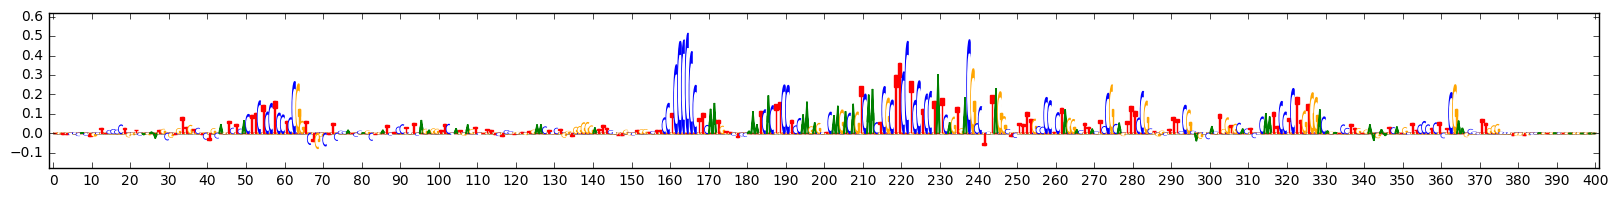

In [35]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (0,197)  #illustrates non-specific firing of guided backprop
                 ]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'rescale_all_layers_avg_gc_ref',
                        #'integrated_gradients10',
                        #'rescale_all_layers',
                        #'rescale_conv_revealcancel_fc',
                        #'rescale_conv_revealcancel_fc_multiref_10',
                        #'rescale_all_layers_multiref_10'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(scores_for_idx)
        original_onehot = onehot_data[idx]
        print("Scores shape: " + str(scores_for_idx.shape))
        print("Onehot shape: " + str(original_onehot.shape))
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
 #       highlight = {'blue':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
 #               'green':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight={})

## Making the scatterplots

I haven't ported the code necessary to generate the scatterplots in the DeepLIFT paper in this version of DeepLIFT. However, for a notebook that reproduces the figures in the paper, feel free to look at https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/examples/public/genomics/genomics_simulation.ipynb